* GloVe网站：https://nlp.stanford.edu/projects/glove/
* fastText网站：https://fasttext.cc/
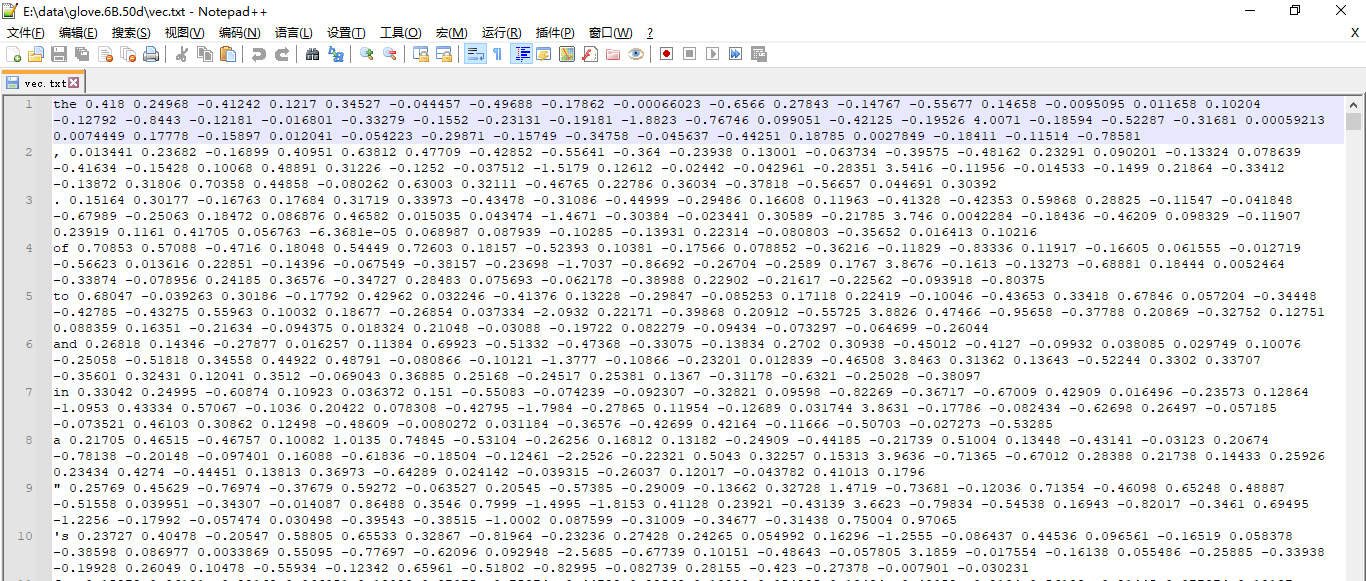

In [1]:
import os
import torch
from torch import nn
import dltools

In [55]:
# @save
class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = "E:/data/glove.6B.50d/"
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r',encoding="utf-8") as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [56]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

In [18]:
len(glove_6b50d)

400001

In [61]:
glove_6b50d.token_to_idx['beautiful'],glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [20]:
# 词相似度
def knn(W, x, k):
    # 增加1e-9以获得数值稳定性
    cos = torch.mv(W, x.reshape(-1,)) / (torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) * torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [21]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # 排除输入词
        print(f'{embed.idx_to_token[int(i)]}：cosine相似度={float(c):.3f}')

In [22]:
get_similar_tokens('chip', 3, glove_6b50d)

chips：cosine相似度=0.856
intel：cosine相似度=0.749
electronics：cosine相似度=0.749


In [23]:
get_similar_tokens('baby', 3, glove_6b50d)

babies：cosine相似度=0.839
boy：cosine相似度=0.800
girl：cosine相似度=0.792


In [24]:
get_similar_tokens('beautiful', 3, glove_6b50d)

lovely：cosine相似度=0.921
gorgeous：cosine相似度=0.893
wonderful：cosine相似度=0.830


In [62]:
# 词类比 man woman : son daughter
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # 删除未知词

In [58]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [63]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [64]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [65]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'